# DBSCAN From Scratch

Density-Based Spatial Clustering with noise detection.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN as SklearnDBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
np.random.seed(42)

---
## DBSCAN Implementation

In [2]:
class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
        self.core_sample_indices_ = None
    
    def fit(self, X):
        n_samples = X.shape[0]
        
        # Compute distance matrix
        distances = cdist(X, X, metric='euclidean')
        
        # Find neighbors within eps
        neighbors = [np.where(distances[i] <= self.eps)[0] for i in range(n_samples)]
        
        # Identify core points
        core_points = np.array([len(n) >= self.min_samples for n in neighbors])
        
        # Initialize labels (-1 = noise)
        labels = np.full(n_samples, -1)
        cluster_id = 0
        
        # Process each core point
        for i in range(n_samples):
            if not core_points[i] or labels[i] != -1:
                continue
            
            # Start new cluster
            labels[i] = cluster_id
            
            # Expand cluster using queue
            queue = list(neighbors[i])
            while queue:
                point = queue.pop(0)
                
                # Skip if already processed
                if labels[point] != -1:
                    continue
                
                # Assign to cluster
                labels[point] = cluster_id
                
                # Add neighbors of core points to queue
                if core_points[point]:
                    queue.extend(neighbors[point])
            
            cluster_id += 1
        
        self.labels_ = labels
        self.core_sample_indices_ = np.where(core_points)[0]
        return self
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

print('DBSCAN class ready')

DBSCAN class ready


---
## Test on Non-Spherical Clusters

In [3]:
# Generate moon-shaped data
X, y_true = make_moons(n_samples=300, noise=0.05, random_state=42)

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'Data shape: {X.shape}')
print(f'True clusters: {len(np.unique(y_true))}')

Data shape: (300, 2)
True clusters: 2


In [4]:
# Our DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('='*60)
print('OUR DBSCAN')
print('='*60)
print(f'Eps: {dbscan.eps}')
print(f'MinPts: {dbscan.min_samples}')
print(f'Clusters found: {n_clusters}')
print(f'Noise points: {n_noise}')
print(f'Core points: {len(dbscan.core_sample_indices_)}')

OUR DBSCAN
Eps: 0.3
MinPts: 5
Clusters found: 2
Noise points: 0
Core points: 299


In [5]:
# sklearn DBSCAN
sklearn_dbscan = SklearnDBSCAN(eps=0.3, min_samples=5)
sklearn_labels = sklearn_dbscan.fit_predict(X_scaled)

n_clusters_sk = len(set(sklearn_labels)) - (1 if -1 in sklearn_labels else 0)
n_noise_sk = list(sklearn_labels).count(-1)

print('='*60)
print('SKLEARN DBSCAN')
print('='*60)
print(f'Clusters found: {n_clusters_sk}')
print(f'Noise points: {n_noise_sk}')
print(f'\nResults match: {n_clusters == n_clusters_sk and n_noise == n_noise_sk}')

SKLEARN DBSCAN
Clusters found: 2
Noise points: 0

Results match: True


---
## Visualize Results

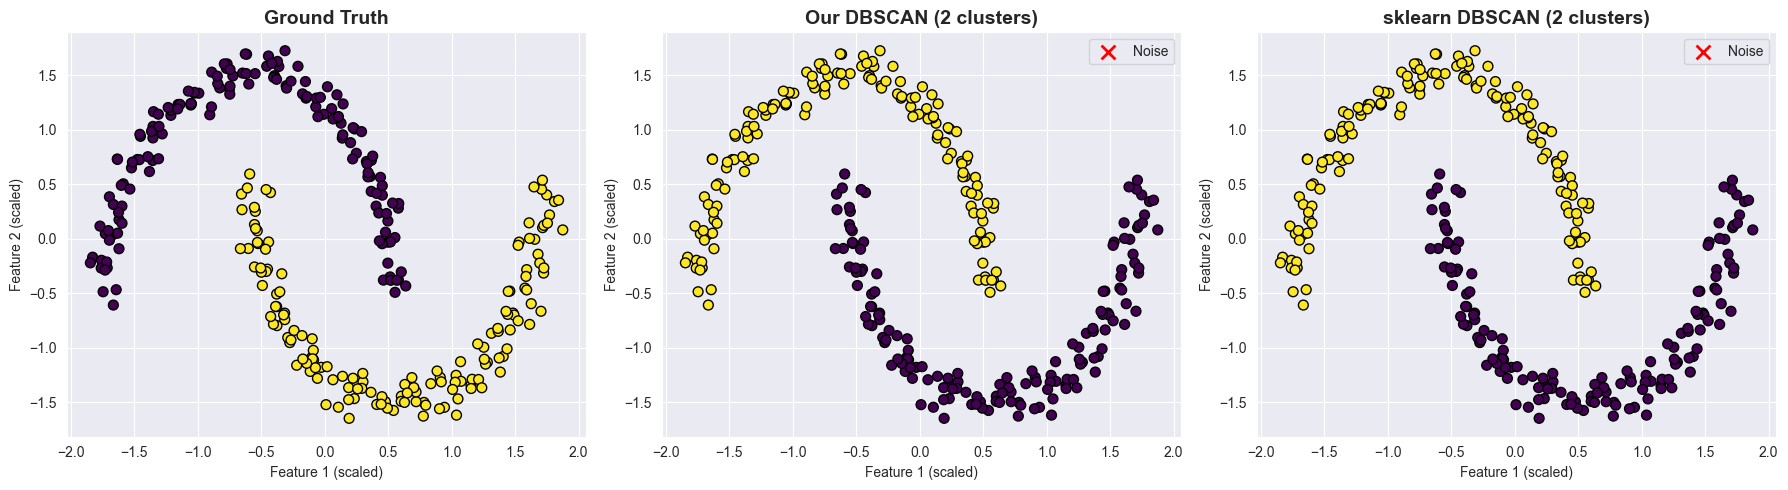

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Ground truth
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_true, cmap='viridis', s=50, edgecolors='k')
axes[0].set_title('Ground Truth', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1 (scaled)')
axes[0].set_ylabel('Feature 2 (scaled)')

# Our DBSCAN
scatter = axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50, edgecolors='k')
# Highlight noise
noise_mask = labels == -1
axes[1].scatter(X_scaled[noise_mask, 0], X_scaled[noise_mask, 1], 
               c='red', s=100, marker='x', linewidths=2, label='Noise')
axes[1].set_title(f'Our DBSCAN ({n_clusters} clusters)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1 (scaled)')
axes[1].set_ylabel('Feature 2 (scaled)')
axes[1].legend()

# sklearn DBSCAN
axes[2].scatter(X_scaled[:, 0], X_scaled[:, 1], c=sklearn_labels, cmap='viridis', s=50, edgecolors='k')
noise_mask_sk = sklearn_labels == -1
axes[2].scatter(X_scaled[noise_mask_sk, 0], X_scaled[noise_mask_sk, 1],
               c='red', s=100, marker='x', linewidths=2, label='Noise')
axes[2].set_title(f'sklearn DBSCAN ({n_clusters_sk} clusters)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Feature 1 (scaled)')
axes[2].set_ylabel('Feature 2 (scaled)')
axes[2].legend()

plt.tight_layout()
plt.show()

---
## K-Distance Plot for Epsilon Selection

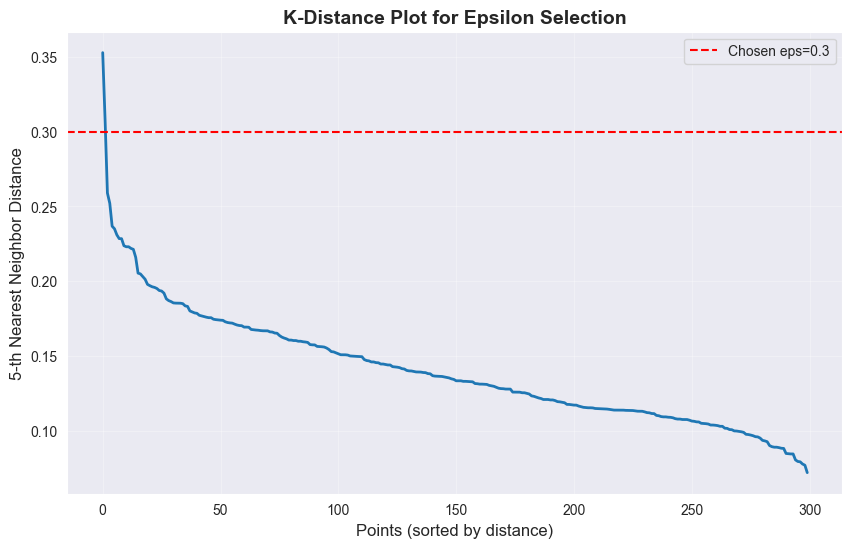

Choose epsilon at the elbow (sharp increase in distance)


In [7]:
# Compute k-nearest neighbor distances
k = 5  # min_samples
distances = cdist(X_scaled, X_scaled, metric='euclidean')

# For each point, find distance to kth nearest neighbor
k_distances = []
for i in range(len(X_scaled)):
    dists = np.sort(distances[i])
    k_distances.append(dists[k])  # kth neighbor (0-indexed, so k gives k+1th)

# Sort in descending order
k_distances_sorted = sorted(k_distances, reverse=True)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_distances_sorted, linewidth=2)
plt.xlabel('Points (sorted by distance)', fontsize=12)
plt.ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=12)
plt.title('K-Distance Plot for Epsilon Selection', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.3, color='r', linestyle='--', label='Chosen eps=0.3')
plt.legend()
plt.show()

print('Choose epsilon at the elbow (sharp increase in distance)')

---
## Effect of Epsilon

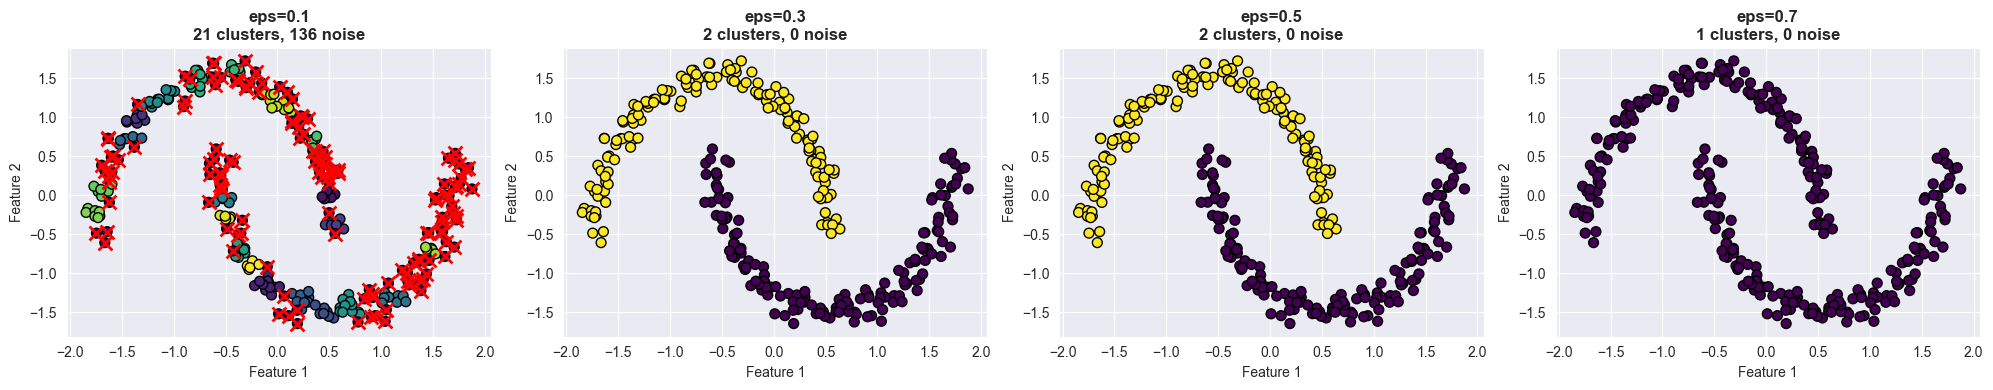

Smaller eps → more clusters, more noise
Larger eps → fewer clusters, less noise


In [8]:
eps_values = [0.1, 0.3, 0.5, 0.7]
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for idx, eps in enumerate(eps_values):
    dbscan_temp = DBSCAN(eps=eps, min_samples=5)
    labels_temp = dbscan_temp.fit_predict(X_scaled)
    
    n_clusters_temp = len(set(labels_temp)) - (1 if -1 in labels_temp else 0)
    n_noise_temp = list(labels_temp).count(-1)
    
    axes[idx].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_temp, cmap='viridis', s=50, edgecolors='k')
    noise_mask = labels_temp == -1
    axes[idx].scatter(X_scaled[noise_mask, 0], X_scaled[noise_mask, 1],
                     c='red', s=100, marker='x', linewidths=2)
    axes[idx].set_title(f'eps={eps}\n{n_clusters_temp} clusters, {n_noise_temp} noise',
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print('Smaller eps → more clusters, more noise')
print('Larger eps → fewer clusters, less noise')

---
## Summary

**Key Points:**
- DBSCAN finds arbitrarily-shaped clusters
- Automatically detects outliers as noise
- No need to specify number of clusters
- Critical to scale data and tune eps/min_samples

**Key Point:** "DBSCAN groups points in dense regions while marking sparse points as noise. Epsilon controls neighborhood size, MinPts controls density threshold. Use k-distance plot to select epsilon systematically."